In [10]:
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
%matplotlib inline

In [3]:
df = pd.read_csv('bank_customers.csv')
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [4]:
# Splitting the data into train and test

X = df.drop(['CustomerId','RowNumber','Surname','Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

In [5]:
# encode the columns Geography (3) and Gender (2)
# bin the columns CreditScore, Age, Balance, EstimatedSalary, then scale them 

X_train['CreditScore'] = pd.cut(X_train['CreditScore'], bins=2, labels=['low_score','high_score'])
X_train['Balance'] = pd.cut(X_train['Balance'], bins=2, labels=['low_balance','high_balance'])
X_train['EstimatedSalary'] = pd.cut(X_train['EstimatedSalary'], bins=2, labels=['low_salary','high_salary'])
X_train['Age'] = pd.cut(X_train['Age'], bins=3, labels=['young','adult','senior'])

In [6]:
X_test['CreditScore'] = pd.cut(X_test['CreditScore'], bins=2, labels=['low_score','high_score'])
X_test['Balance'] = pd.cut(X_test['Balance'], bins=2, labels=['low_balance','high_balance'])
X_test['EstimatedSalary'] = pd.cut(X_test['EstimatedSalary'], bins=2, labels=['low_salary','high_salary'])
X_test['Age'] = pd.cut(X_test['Age'], bins=3, labels=['young','adult','senior'])

In [7]:
ct = ColumnTransformer([
    ('one-hot-encoding', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['CreditScore','Geography','Gender','Age','Balance','EstimatedSalary']),
    ('scaler', MinMaxScaler(), ['Tenure']),
    ('keep', 'passthrough', ['NumOfProducts','HasCrCard','IsActiveMember'])
    ])

In [8]:
ct.fit(X_train)
X_train_trans = ct.transform(X_train)

In [9]:
#ct.fit(X_test)

ColumnTransformer(transformers=[('one-hot-encoding',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['CreditScore', 'Geography', 'Gender', 'Age',
                                  'Balance', 'EstimatedSalary']),
                                ('scaler', MinMaxScaler(), ['Tenure']),
                                ('keep', 'passthrough',
                                 ['NumOfProducts', 'HasCrCard',
                                  'IsActiveMember'])])

In [9]:
X_test_trans = ct.transform(X_test)

In [9]:
lr = LogisticRegression()
lr.fit(X_train_trans, y_train)
lr.predict(X_test_trans)

y_pred = lr.predict(X_test_trans)

array([0, 0, 1, ..., 1, 0, 0])

In [22]:
# evaluate the model

print(
"LR train score:", round(lr.score(X_train_trans, y_train),3),
"\nLR test score:", round(lr.score(X_test_trans, y_test),3),
"\nLR f1 score:", round(f1_score(y_test, y_pred),3),
"\nLR recall score:", round(recall_score(y_test, y_pred),3),
"\nLR precision score:", round(precision_score(y_test, y_pred),3)
)

LR train score: 0.822 
LR test score: 0.83 
LR f1 score: 0.425 
LR recall score: 0.321 
LR precision score: 0.63


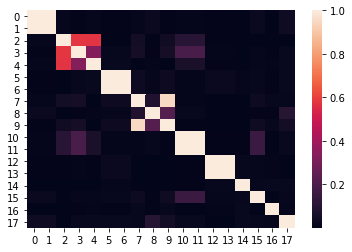

In [13]:
X_train_trans = pd.DataFrame(X_train_trans)
sns.heatmap(abs(X_train_trans.corr()))

In [30]:
prediction = pd.DataFrame({'Exited': y_pred})
prediction

,Exited
0,0
1,0
2,1
3,0
4,0
...,...
1995,1
1996,0
1997,1
1998,0


In [31]:
prediction.to_csv('predictions_lr.csv', index=False)

## Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini')
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(
    "RF train score:", round(rf.score(X_train, y_train), 3),
    "\nRF test score:", round(rf.score(X_test, y_test), 3),
    "\nRF precision score:", round(precision_score(y_test, rf_pred), 3),
    "\nRF recall score:", round(recall_score(y_test, rf_pred), 3),
    "\nRF f1 score:", round(f1_score(y_test, rf_pred), 3)
)

NameError: name 'RandomForestClassifier' is not defined

## Auto-ML

In [11]:
lazy_clf = LazyClassifier()
models, lazy_pred = lazy_clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.82,0.62,0.62,0.80,0.08
QuadraticDiscriminantAnalysis,0.60,0.62,0.62,0.64,0.08
RandomForestClassifier,0.82,0.62,0.62,0.80,0.41
AdaBoostClassifier,0.83,0.62,0.62,0.80,0.20
SVC,0.83,0.62,0.62,0.80,1.83
NearestCentroid,0.60,0.61,0.61,0.64,0.03
LabelSpreading,0.82,0.61,0.61,0.79,2.55
LGBMClassifier,0.83,0.61,0.61,0.80,0.16
KNeighborsClassifier,0.81,0.61,0.61,0.79,0.12
